# Tropical Cyclones - Covariance matrix of the wind fields by Saffir-Simpson category

Group 1: Jérémie Lambert, Emmanuel Leguet

![Image of a cyclone](https://costarica-decouverte.com/wp-content/uploads/2018/02/cyclone-costa-rica-decouverte.jpg)

# Introduction

## Description

The dataset consists of 341 files in one global xarray.Dataset stored in .zarr format. Each file contains a SAR acquisition of one TC at one instant time, as well as the computed wind field associated with the satellite signal. Each file also contains additional information, such as the storm name, ID, and category (= category at the time of the acquisition).

The specificity of this dataset (compared to other TC datasets) is its spatial resolution, which reaches 1 km in both x and y directions. The counterpart is its temporal resolution, which is very low: TC images are acquired when the (polar-orbiting) satellite overpasses a TC (and only if the operational chain decided to put the sensor on at this moment), which leads to an irregular sampling in time. 

The goal of the project is to compute some statistical properties about the TCs of the dataset. This includes statistics about:

- **GROUP 1: covariance matrix of the wind fields by Saffir-Simpson category;**

- GROUP 2: spatial and temporal coverage of the TCs (basins, seasons), mean wind field by Saffir-Simpson category, as well as statistical distribution of some important metrics (Vmax, Rmax, R64, R50, R34);

## Install & Imports

In [ ]:
!pip install --upgrade pyyaml==5.4.1 tqdm gcsfs zarr dask xarray scipy datetime

     |████████████████████████████████| 636 kB 18.1 MB/s 
     |████████████████████████████████| 146 kB 35.3 MB/s 
     |████████████████████████████████| 1.0 MB 44.4 MB/s 
     |████████████████████████████████| 845 kB 42.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 60 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 59.8 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
     |████████████████████████████████| 271 kB 53.5 MB/s 
     |████████████████████████████████| 160 kB 58.1 MB/s 
     |████████████████████████████████| 144 kB 48.2 MB/s 
     |████████████████████████████████| 6.2 MB 51.7 MB/s 
     |████████████████████████████████| 251 kB 57.3 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=7f5f03dbef01ce6f5cc07a0cc9be90e93f88bc4a02f3188e6cab3de8c281a106
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b

In [ ]:
from tqdm import tqdm
import gcsfs
import zarr
import dask as da
from matplotlib import colors
import xarray as xr
import numpy as np
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import seaborn as sns

from scipy.interpolate import griddata
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Access Dataset

In [ ]:
# OPEN DATASET
fs     = gcsfs.GCSFileSystem(project='ds2class-2021', token='anon', access='read_only')
gcsmap = fs.get_mapper("project10_tc_sar/zarr_data/tc_sar_data.zarr")
ds_all = xr.open_zarr(gcsmap)
N_cyc = len(ds_all.time) # Number of cyclone images
ds_all

In [ ]:
# Get category for each cyclone
cats = ds_all.cat.to_numpy()
N_cats = cats.max()+1 # Number of categories
print("Number of cyclone images for each category:")
Counter(cats)

## Utils

In [ ]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    '''Given an xarray.Dataset object containing all the files (e.g 341) and a time index, plots the corresponding TC wind field using plt.pcolormesh().'''
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('%i - SAR wind field\n%s, %s, Cat. %i'%(time_idx, name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3

In [ ]:
### COMPUTING COVARIANCE
# We don't use directly the cov function to deal with the nan values
def covariance(X:np.array) -> np.array:
    # Center data
    X_centered = X - np.nanmean(X, axis=0)
    # Compute cov
    C = np.nanmean(np.array([np.outer(x,x) for x in X_centered]), axis=0)
    return C

## Cyclone image example

In [ ]:
cyclone_idx = np.random.randint(0, N_cyc)
plot_wind_field(ds_all, cyclone_idx)

# Covariance matrix in cartesian coordinates

## Covariance matrix

In [ ]:
# Crop data
xy_lim = 250000
crop_ds_all = ds_all.sel(x=slice(-xy_lim, xy_lim-1), y=slice(-xy_lim, xy_lim-1))

# Retrieve a subset of the wind speed data
n_freq = 10
wind_speed = crop_ds_all.wind_speed[:,::n_freq,::n_freq].values

# Vectorize data
X = wind_speed.reshape(N_cyc,-1)

# Compute covariance
Cov_by_cat = [covariance(X[cats == i]) for i in range(N_cats)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


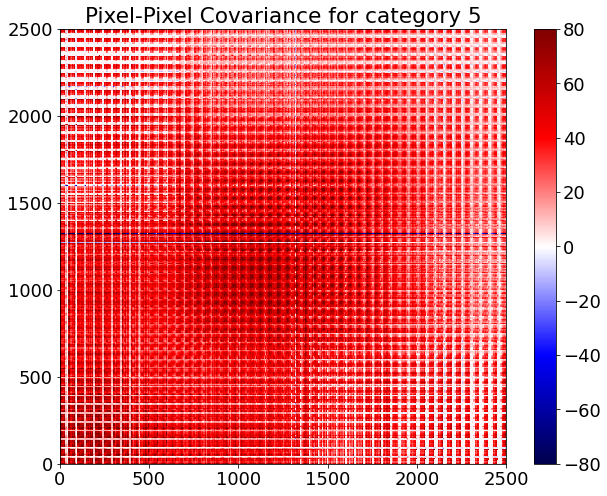

In [ ]:
# Plot covariance matrix for a category
category = 5
plt.figure(figsize=(10,8))
divnorm = colors.TwoSlopeNorm(vmin=-80, vcenter=0., vmax=80)
plt.title(f'Pixel-Pixel Covariance for category {category}')
plt.pcolormesh(Cov_by_cat[category], cmap="seismic", norm=divnorm)
plt.colorbar()
plt.show()

The negative values are surprising, below we look at what pixels they correspond to: the pixels just around the eye.

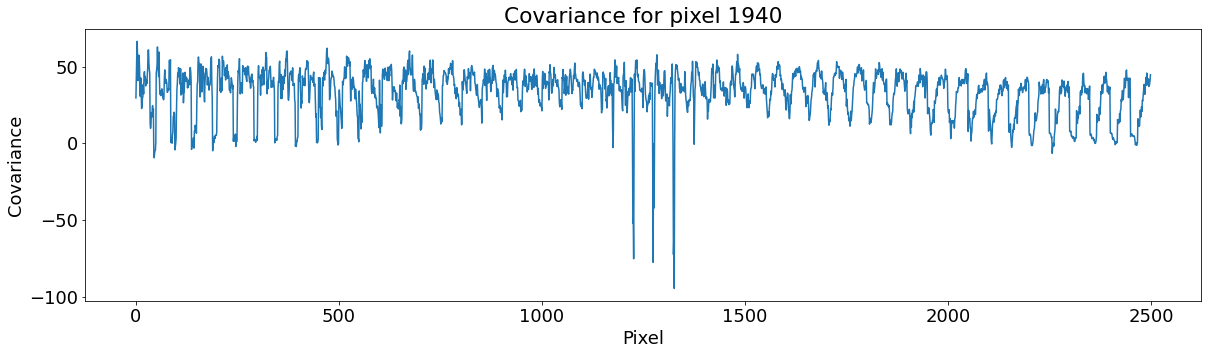

In [ ]:
# Plot covariance for one pixel
pix_ind = np.random.randint(X.shape[1])
plt.figure(figsize=(20,5))
plt.plot(Cov_by_cat[category][pix_ind])
plt.title(f'Covariance for pixel {pix_ind}')
plt.xlabel('Pixel')
plt.ylabel('Covariance')
plt.show()

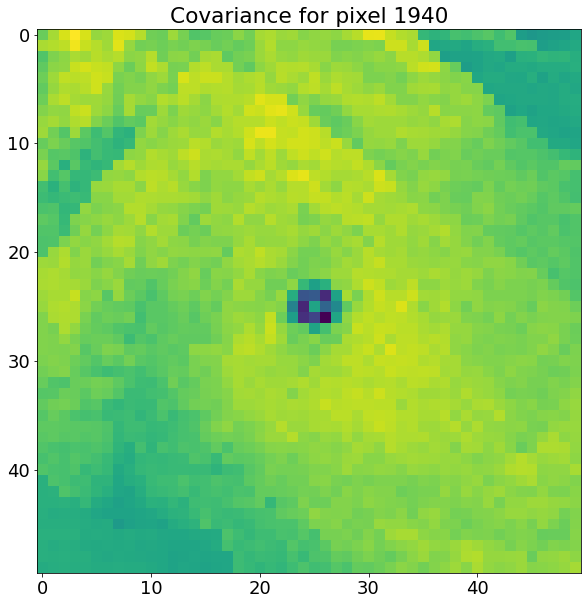

In [ ]:
# Plot pixels covariance for a pixel
plt.title(f'Covariance for pixel {pix_ind}')
im = Cov_by_cat[category][pix_ind].reshape(*wind_speed.shape[1:])
plt.imshow(im)
plt.show()

We try to identify the pixel with negative covariance (blue lines).

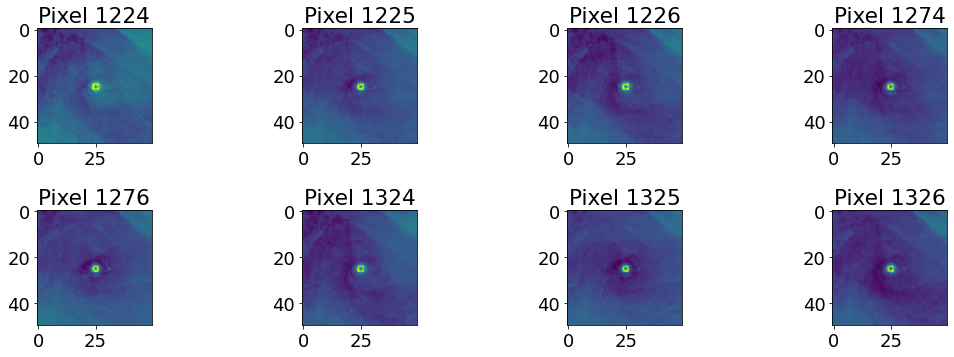

In [ ]:
# Plot covariance for pixel (blue lines)
threshold = -25
pixels_blue_lines = np.where(Cov_by_cat[category][pix_ind] < threshold)[0]
for i,ind in enumerate(pixels_blue_lines):
    if i > 15: break
    plt.subplot(4,4,i+1)
    plt.title(f'Pixel {ind}')
    im = Cov_by_cat[category][ind].reshape(*wind_speed.shape[1:])
    plt.imshow(im)
plt.tight_layout()
plt.show()

## PCA

We can use the covariance matrix for a pca. However, we need to fill the nan. We replace them with 0 in the covariance matrix.

In [ ]:
# Eigen decomposition of covariance matrix
category = 5
values, vectors = np.linalg.eig(np.nan_to_num(Cov_by_cat[category]))
print(vectors.shape)
print(values.shape)

(2500, 2500)
(2500,)


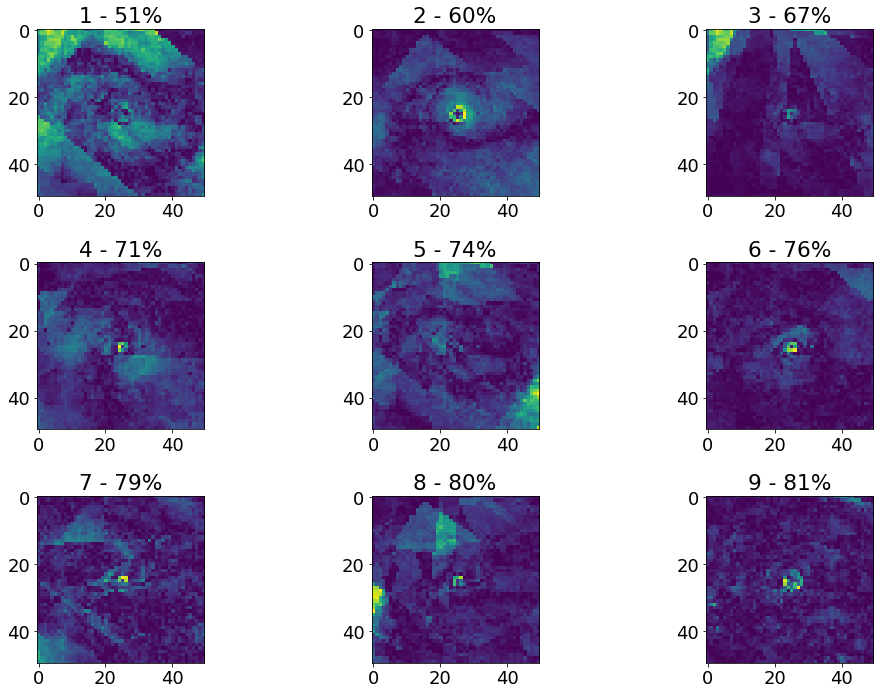

In [ ]:
# Plot the first eigen vectors
plt.figure()
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(abs(vectors.T[i,:]).reshape(*wind_speed.shape[1:]))
    explained_var = int(round((np.cumsum(abs(values[:i]))[-1] / abs(values).sum())*100))
    plt.title(f'{i} - {explained_var}%')
plt.tight_layout()
plt.show()

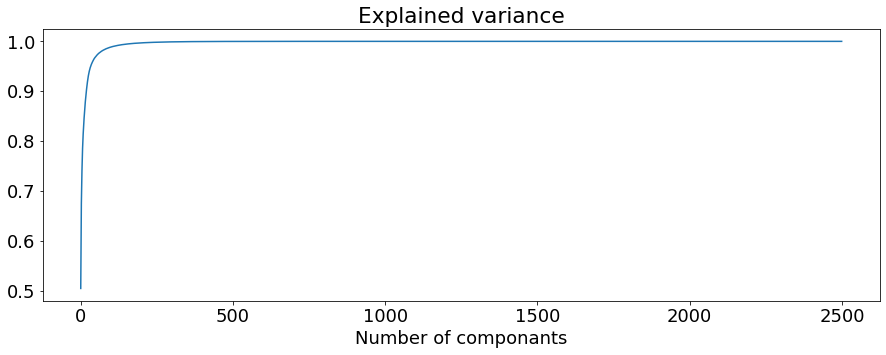

In [ ]:
# Explained variance
plt.figure(figsize=(15,5))
plt.title("Explained variance")
plt.plot(np.arange(X.shape[1]), np.cumsum(abs(values)) / abs(values).sum())
plt.xlabel("Number of componants")
plt.show()

# Polar coordinates & Rmax-R*

## Add polar coordinates as data variables

We add radius *r* and angle *theta* in the xarray dataset

In [ ]:
ds_all = ds_all.assign(r = lambda d : np.sqrt(d.x**2 + d.y**2))
ds_all = ds_all.assign(theta = lambda d : np.arctan2(d.y,d.x)) # Zero is on the right
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/37)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    r                                              (x, y) float64 7.057e+05 ....
    theta                                          (y, x) float64 -2.356 ... ...

## Compute Rmax

### Basic approach

Rmax is the distance to the center of the position with maximum wind speed.

In [ ]:
# Crop data
xy_lim = 250000
crop_ds_all = ds_all.sel(x=slice(-xy_lim, xy_lim-1), y=slice(-xy_lim, xy_lim-1))

# Get indexes of x and y coordinates for max wind speed
x_max_indexes = crop_ds_all.wind_speed.argmax(dim=["x", "y"], skipna=True)["x"].values
y_max_indexes = crop_ds_all.wind_speed.argmax(dim=["x", "y"], skipna=True)["y"].values

In [ ]:
# Retrieve Rmaxs and Vmaxs
rmaxs_basic = np.array([crop_ds_all.r.isel(x=x_i, y=y_i).values for x_i,y_i in zip(x_max_indexes,y_max_indexes)])
vmax_maxs_basic = np.array([crop_ds_all.wind_speed.isel(x=x_i, y=y_i, time=i).values for i,(x_i,y_i) in enumerate(zip(x_max_indexes,y_max_indexes))])

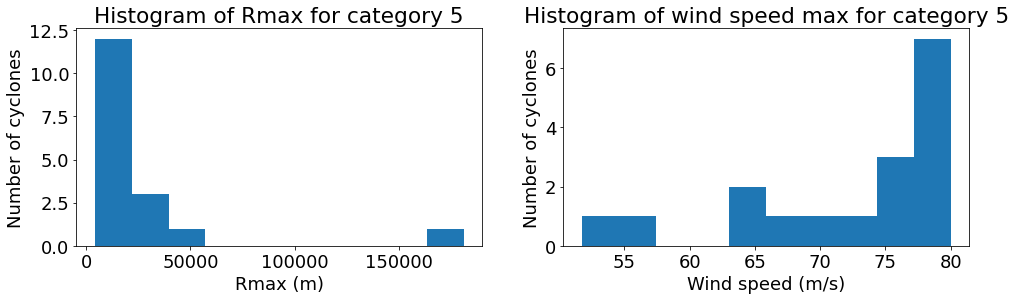

In [ ]:
# Plot a histogram for a category
cat = 5

plt.figure(figsize=(16,4))
# Rmax
plt.subplot(1,2,1)
plt.title(f"Histogram of Rmax for category {cat}")
plt.hist(rmaxs_basic[cats==cat])
plt.xlabel("Rmax (m)")
plt.ylabel("Number of cyclones")
# Vmax
plt.subplot(1,2,2)
plt.title(f"Histogram of wind speed max for category {cat}")
plt.hist(vmax_maxs_basic[cats==cat])
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Number of cyclones")
plt.show()

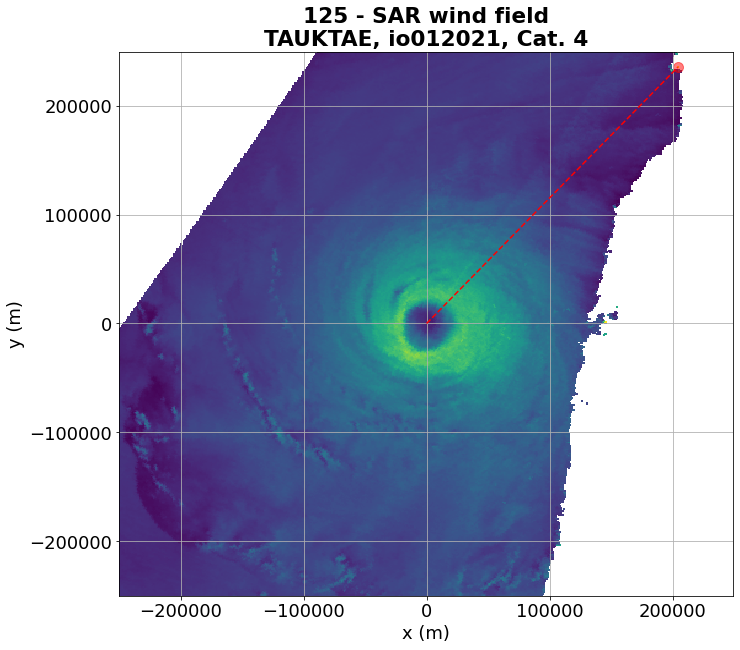

In [ ]:
# Display results for maximum Rmax
plt.figure(figsize=(11,10))
r_i = np.argmax(rmaxs_basic)
x_, y_ = crop_ds_all.y[y_max_indexes[r_i]], crop_ds_all.x[x_max_indexes[r_i]]
# Title
name = crop_ds_all.isel(time=r_i)['storm_name'].values
tcId = crop_ds_all.isel(time=r_i)['storm_id'].values
cat  = int(crop_ds_all.isel(time=r_i)['cat'])
plt.title('%i - SAR wind field\n%s, %s, Cat. %i'%(r_i, name, tcId, cat), weight='bold')
# Plot
x, y = np.meshgrid(crop_ds_all.isel(time=r_i)['x'], crop_ds_all.isel(time=r_i)['y']) # Defining 2D coordinates
plt.pcolormesh(x, y, crop_ds_all.isel(time=r_i)['wind_speed'])                       # Plot the wind field
plt.scatter(x_,y_, c='r', s=100, alpha=0.5)
plt.plot([0,x_],[0,y_], linestyle='--', c='r')
plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid() 
plt.show()

### Our method
We look at the mean value of pixels which belong to different intervals of radius and select Rmax as the middle of the radius interval with maximum mean wind speed. The function below also uses the median. 

In [ ]:
def compute_rmax(t:int, s=2000, n=75):
    r = ds_all.r.values.flatten()
    w = ds_all.isel(time=t).wind_speed.values.flatten()
    intervals = [(r > i*s)*(r < (i+1)*s) for i in range(n)]
    i_max_mean = np.argmax([np.nanmean(w[i]) for i in intervals])
    i_max_median = np.argmax([np.nanmedian(w[i]) for i in intervals])
    r_max_mean = r[intervals[i_max_mean]].mean()
    r_max_median = r[intervals[i_max_median]].mean()
    return r_max_mean, r_max_median

* Potential long runtime*

In [ ]:
# Compute all rmaxs
all_rmaxs = np.array([compute_rmax(t) for t in range(N_cyc)])

In [ ]:
# Plot a histogram for a category
cat = 5

plt.figure(figsize=(16,4))
# Rmax
plt.subplot(1,2,1)
plt.title(f"Histogram of Rmax for category {cat}")
plt.hist(all_rmaxs[cats==cat], label=["Mean", "Median"])
plt.xlabel("Rmax (m)")
plt.ylabel("Number of cyclones")
plt.legend()
plt.show()

In [ ]:
# Display results for maximum Rmax (Mean)
fig, ax = plt.subplots(figsize=(11,10))
r_i = np.argmax(all_rmaxs[:,0])
r_max = all_rmaxs[r_i,0]
# Title
name = ds_all.isel(time=r_i)['storm_name'].values
tcId = ds_all.isel(time=r_i)['storm_id'].values
cat  = int(ds_all.isel(time=r_i)['cat'])
plt.title('%i - SAR wind field\n%s, %s, Cat. %i'%(r_i, name, tcId, cat), weight='bold')
# Plot
x, y = np.meshgrid(ds_all.isel(time=r_i)['x'], ds_all.isel(time=r_i)['y']) # Defining 2D coordinates
plt.pcolormesh(x, y, ds_all.isel(time=r_i)['wind_speed'])                       # Plot the wind field
ax.add_patch(plt.Circle((0,0), r_max, fill=False, color='r'))
plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid() 
plt.show()

## Compute R* (normalization)

### Interpolation representation
Below we show the pixels we got from the data grid (source) and those on which we want to interpolate the wind speed for the new data grid (target). Our data grid is regular in r and theta. We show the points in r-theta and x-y representation.

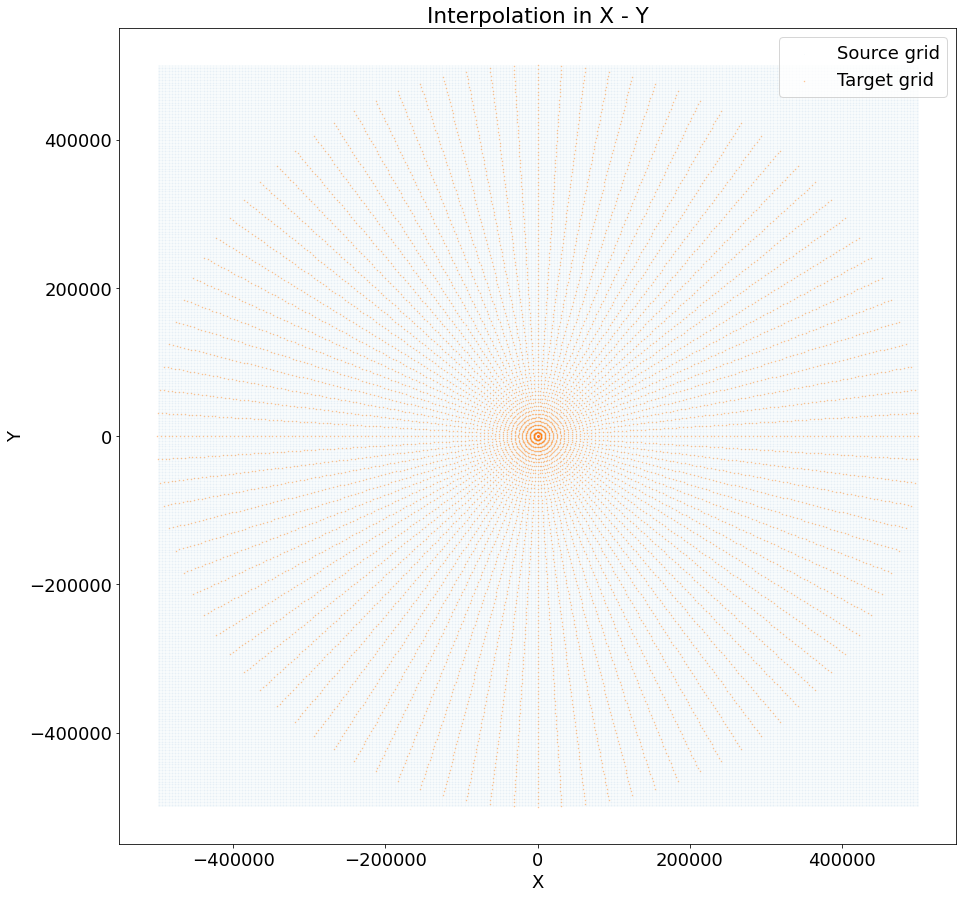

In [ ]:
# Target grid
Rlim = 500000
n_r, n_th = 100, 100
grid_R, grid_Th = np.mgrid[0:Rlim:complex(0,n_r), -np.pi:np.pi-2*np.pi/n_th:complex(0,n_th)]

plt.figure(figsize=(15,15))
plt.title('Interpolation in X - Y')
plt.scatter(*np.meshgrid(ds_all.x, ds_all.y), s=0.0001, label='Source grid')
plt.scatter(grid_R * np.cos(grid_Th), grid_R * np.sin(grid_Th), s=0.2, alpha=0.5, label='Target grid')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="upper right")
plt.show()

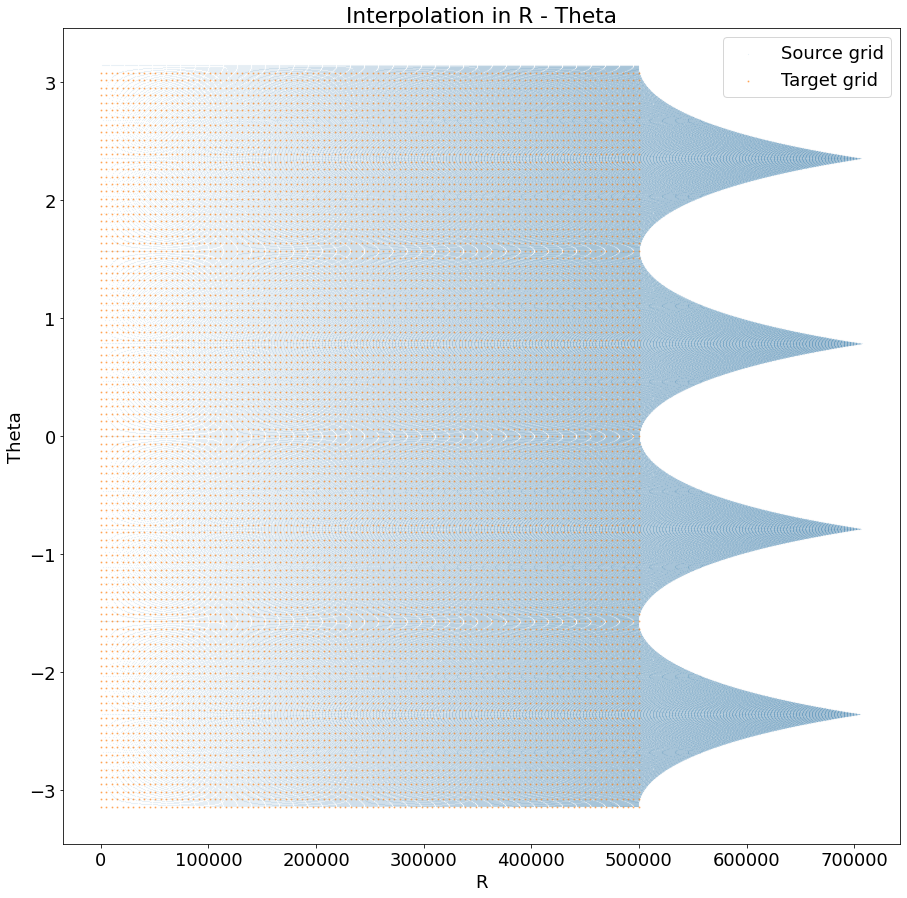

In [ ]:
plt.figure(figsize=(15,15))
plt.title('Interpolation in R - Theta')
plt.scatter(ds_all.r, ds_all.theta, s=0.001, label='Source grid')
plt.scatter(grid_R, grid_Th, s=1, alpha=0.5, label='Target grid')
plt.xlabel('R')
plt.ylabel('Theta')
plt.legend(loc="upper right")
plt.show()

### Normalization to R*
Here, we normalize the data such as all cyclone as their Rmax at R* = 1, in r*-theta coordinates. To do that, we just divide by Rmax the source grid before interpolating.

In [ ]:
# Parameters
time_i = 15
r_ratio_max = 8
p_r, p_th = 100, 100

# Target grids
grid_R, grid_Th = np.mgrid[0:r_ratio_max:complex(0,p_r), -np.pi:np.pi:complex(0,p_th)]

# Normalized source grids
R_source, Theta_source = ds_all.r.values, ds_all.theta.values
rmax_i = compute_rmax(time_i)[0]
R_star_source = R_source / rmax_i

# Points and values source
points = np.c_[R_star_source.flatten(), Theta_source.flatten()]
wind_values_i = ds_all.isel(time=time_i).wind_speed.values.flatten()

# Interpolation
wind_polar_i = griddata(points, wind_values_i, (grid_R, grid_Th), method='nearest')

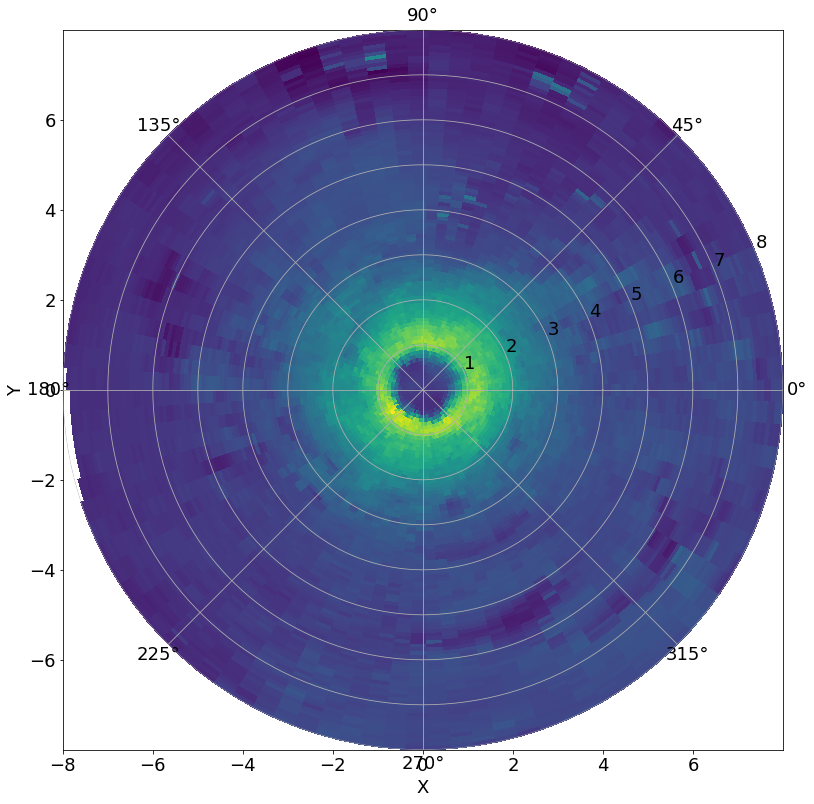

In [ ]:
# initializing the figure
fig = plt.figure(figsize=(10,10))
# setting the axis limits in [left, bottom, width, height]
rect = [-1, -1, 1, 1]

# plotting the line on the carthesian axis
ax_carthesian  = fig.add_axes(rect)
ax_carthesian.pcolormesh(grid_R*np.cos(grid_Th), grid_R*np.sin(grid_Th), wind_polar_i, alpha=1)
ax_carthesian.set_xlabel('X')
ax_carthesian.set_ylabel('Y')

# the polar plot
ax_polar = fig.add_axes(rect, polar=True, frameon=False)
ax_polar.pcolormesh(grid_Th, grid_R, wind_polar_i, alpha=0)
ax_polar.grid(True)

plt.show()

# Covariance in R*-Theta Coordinates

## Retrieve wind speed in r* - theta
We retrieve all wind speed values in a r*-theta grid.

In [ ]:
# Parameters
r_ratio_max = 8
n_r, n_th = 32, 360

# Target grids
grid_R, grid_Th = np.mgrid[0:r_ratio_max:complex(0,n_r), -np.pi:np.pi:complex(0,n_th)]

# Source grids
R_source, Theta_source = ds_all.r.values, ds_all.theta.values

# Result array
wind_polars = np.zeros((N_cyc, n_r, n_th))

for time_i in tqdm(range(N_cyc)):
    # Rmax value
    rmax_i = compute_rmax(time_i)[0]

    # Normalize R to R*
    R_star_source = R_source / rmax_i

    # Points and values source
    points = np.c_[R_star_source.flatten(), Theta_source.flatten()]
    wind_values_i = ds_all.isel(time=time_i).wind_speed.values.flatten()

    # Interpolation
    wind_polar_i = griddata(points, wind_values_i, (grid_R, grid_Th), method='nearest')

    # Mean over R*
    wind_polars[time_i,:] = wind_polar_i

## Covariance along radius R*

In [ ]:
# Mean on theta
wind_polars_r = np.nanmean(wind_polars, axis=2)
wind_polars_r.shape

In [ ]:
# Compute covariance
Cov_by_cat_r = [covariance(wind_polars_r[cats == c]) for c in range(N_cats)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


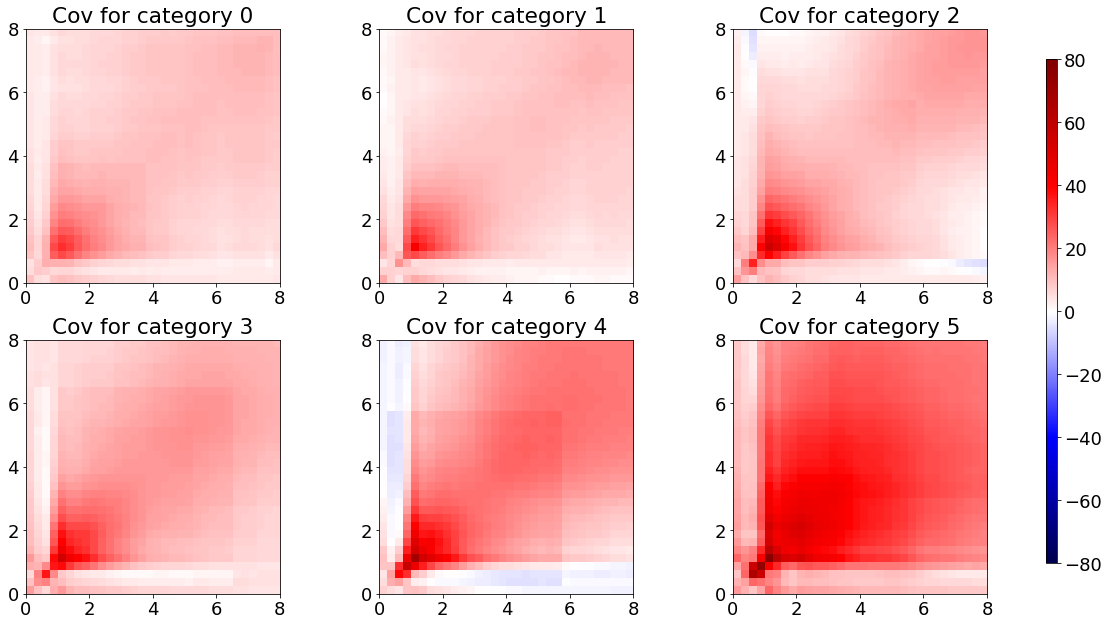

In [ ]:
# Plot covariance matrices
fig, axes = plt.subplots(nrows=2, ncols=3)

for i,ax in enumerate(axes.flat):
    ax.set_title(f'Cov for category {i}')
    ims = ax.imshow(
        Cov_by_cat_r[i], 
        cmap="seismic", 
        norm=colors.TwoSlopeNorm(vmin=-80, vcenter=0, vmax=80), 
        origin='lower', 
        extent=[0,8,0,8])

cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
fig.colorbar(ims, cax=cbar_ax)
plt.subplots_adjust(wspace=1.5)
fig.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()

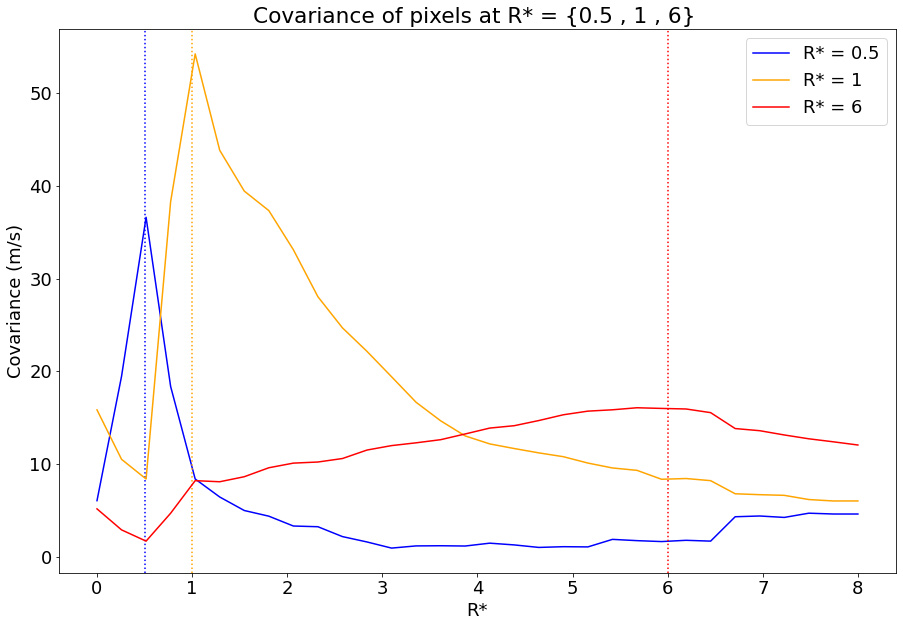

In [ ]:
plt.plot(np.linspace(0,8,32),Cov_by_cat_r[3][2,:],label = "R* = 0.5",color="blue")
plt.axvline(0.5,color="blue",linestyle = "dotted")
plt.plot(np.linspace(0,8,32),Cov_by_cat_r[3][4,:],label = "R* = 1",color ="orange")
plt.axvline(1,color="orange",linestyle = "dotted")
plt.plot(np.linspace(0,8,32),Cov_by_cat_r[3][25,:],label = "R* = 6",color = "red")
plt.axvline(6,color="red",linestyle = "dotted")
plt.legend()
plt.xlabel("R*")
plt.ylabel("Covariance (m/s)")
plt.title("Covariance of pixels at R* = {0.5 , 1 , 6} ")
plt.show()

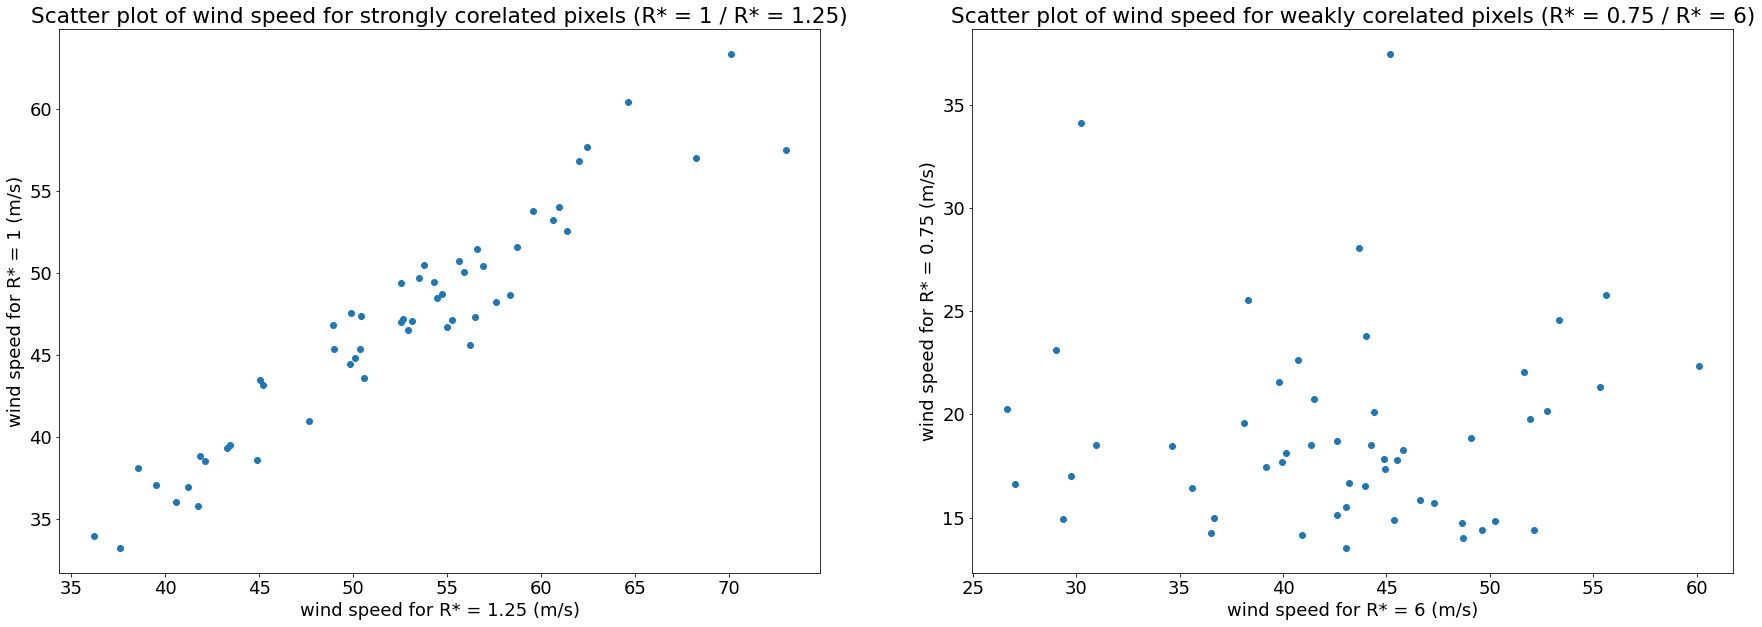

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(121)
plt.scatter(wind_polars_r[cats == 4][:,4], wind_polars_r[cats == 4][:,5])
plt.title("Scatter plot of wind speed for strongly corelated pixels (R* = 1 / R* = 1.25)")
plt.xlabel("wind speed for R* = 1.25 (m/s)")
plt.ylabel("wind speed for R* = 1 (m/s)")
plt.subplot(122)
plt.scatter(wind_polars_r[cats == 4][:,3], wind_polars_r[cats == 4][:,24])
plt.title("Scatter plot of wind speed for weakly corelated pixels (R* = 0.75 / R* = 6)")
plt.xlabel("wind speed for R* = 6 (m/s)")
plt.ylabel("wind speed for R* = 0.75 (m/s)")
plt.show()

## Covariance along Theta

In [ ]:
# Mean on r*
wind_polars_theta = np.nanmean(wind_polars, axis=1)
wind_polars_theta.shape

In [ ]:
# Compute covariance
Cov_by_cat_theta = [covariance(wind_polars_theta[cats == c]) for c in range(N_cats)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


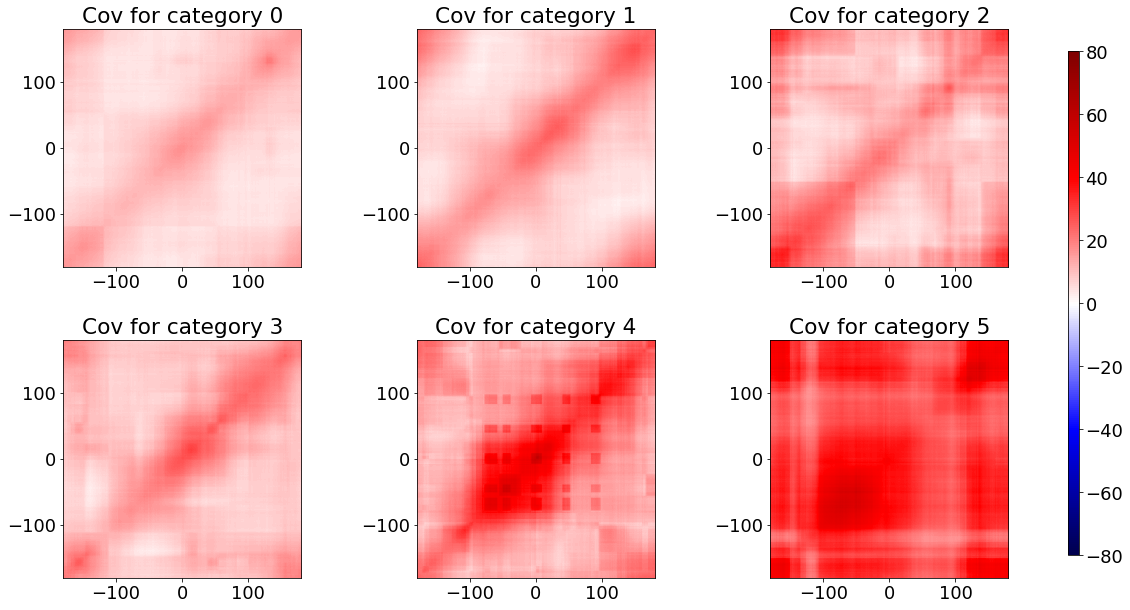

In [ ]:
# Plot covariance matrices
fig, axes = plt.subplots(nrows=2, ncols=3)

for i,ax in enumerate(axes.flat):
    ax.set_title(f'Cov for category {i}')
    ims = ax.imshow(
        Cov_by_cat_theta[i], 
        cmap="seismic", 
        norm=colors.TwoSlopeNorm(vmin=-80, vcenter=0, vmax=80), 
        origin='lower', 
        extent=[-180,180,-180,180])

cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
fig.colorbar(ims, cax=cbar_ax)
plt.subplots_adjust(wspace=1.5)
fig.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()

# Wind speed statistics

## Smooth wind speed histogram

*Potential long runtime*

In [ ]:
# Retrieve all wind speed values
All_winds = ds_all.wind_speed.values

In [ ]:
# Limit the radius range
radius_max = 250 # km
All_winds_lim = All_winds[:, ds_all.r.values < radius_max*1000]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


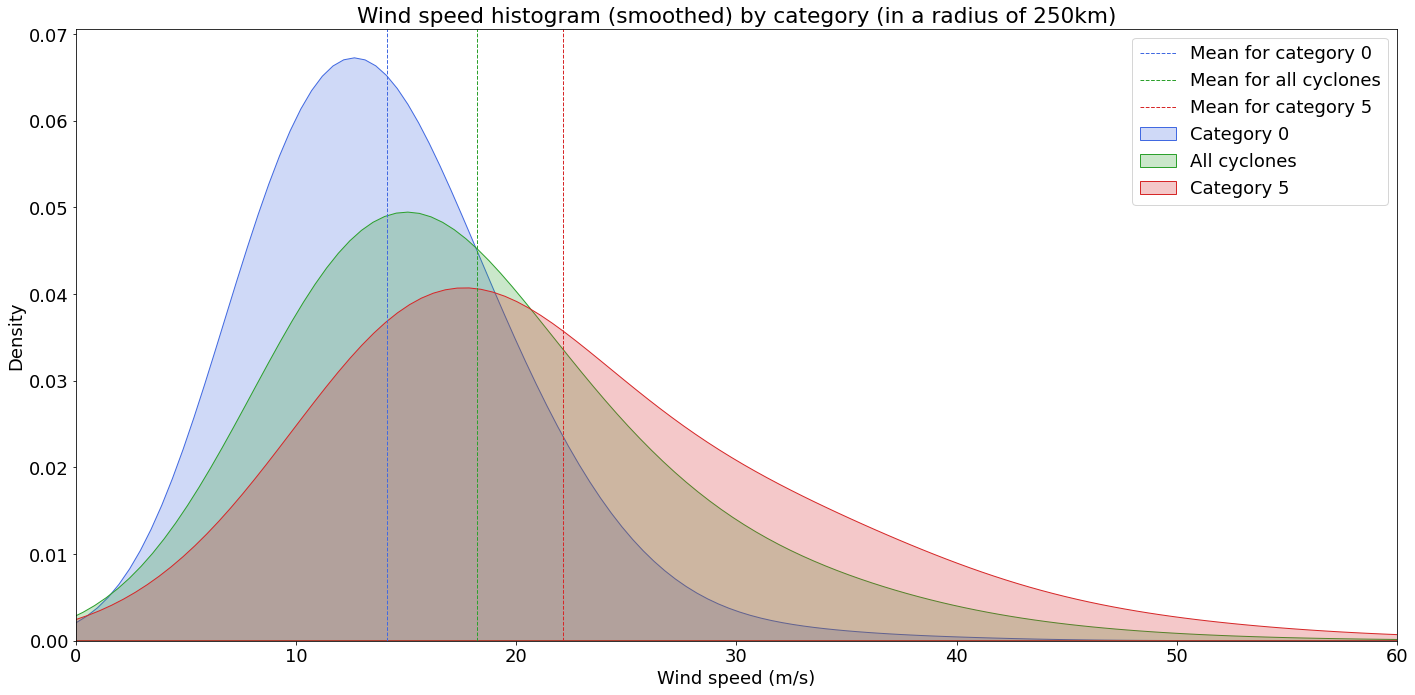

In [ ]:
wind_speed_lim = 60 # m/s
n_freq = 100 # To limit computation time
cat_0_val = All_winds_lim[cats==0].flatten()[::n_freq]
cat_5_val = All_winds_lim[cats==5].flatten()[::n_freq]
all_cat_val = All_winds_lim.flatten()[::n_freq]

plt.figure(figsize=(20,10))
plt.title(f'Wind speed histogram (smoothed) by category (in a radius of {radius_max}km)')

# Smoothed histograms
sns.kdeplot(cat_0_val, bw=0.5, shade=True, label=f"Category 0", color="royalblue")
sns.kdeplot(all_cat_val, bw=0.5, shade=True, label="All cyclones", color="tab:green")
sns.kdeplot(cat_5_val, bw=0.5, shade=True, label=f"Category 5", color="tab:red")

# Mean vertical lines
plt.axvline(np.nanmean(cat_0_val), color='k', linestyle='dashed', linewidth=1, label=f"Mean for category 0", c="royalblue")
plt.axvline(np.nanmean(all_cat_val), color='k', linestyle='dashed', linewidth=1, label=f"Mean for all cyclones", c="tab:green")
plt.axvline(np.nanmean(cat_5_val), color='k', linestyle='dashed', linewidth=1, label=f"Mean for category 5", c="tab:red")

plt.xlim(0,wind_speed_lim)
plt.xlabel("Wind speed (m/s)")
plt.legend()
plt.tight_layout()
plt.show()

## Wind speed mean and variance

In [ ]:
xy_res = 1000
Rmax = 500000

r_ratio_max = 8
p_r, p_th = 100, 100

grid_R, grid_Th = np.mgrid[0:r_ratio_max:complex(0,p_r), -np.pi:np.pi:complex(0,p_th)]

X_target = grid_R * np.cos(grid_Th)
Y_target = grid_R * np.sin(grid_Th)

ds_crop = ds_all.sel(x=slice(-Rmax-xy_res, Rmax+xy_res), y=slice(-Rmax-xy_res, Rmax+xy_res))
X_source, Y_source = np.meshgrid(ds_crop.x.values, ds_crop.y.values)

std_by_r = np.zeros((len(cats), p_r))
w = []
for time_i in tqdm(range(len(cats))):

    rmax_i = compute_rmax(time_i)[0]

    points = np.c_[X_source.flatten(), Y_source.flatten()] / rmax_i
    wind_values_xy = ds_all.isel(time=time_i).wind_speed.sel(x=slice(-Rmax-xy_res, Rmax+xy_res), y=slice(-Rmax-xy_res, Rmax+xy_res)).values.flatten()

    wind_polar = griddata(points, wind_values_xy, (X_target, Y_target), method='nearest')
    wind_polar[grid_R > (Rmax/rmax_i)] = np.nan

    w.append(wind_polar)

In [ ]:
interval = 100
fig, ax = plt.subplots(1)
for i in range(6):
  wind_4 = np.array(w)[cats==i]
  ax.plot(np.linspace(0,r_ratio_max,p_r),np.nanmean(np.nanmean(wind_4,axis=2),axis=0),label = "category {}".format(i))
  ax.fill_between(np.linspace(0,r_ratio_max,p_r),np.nanmean(np.nanmean(wind_4,axis=2),axis=0)+np.nanmean(np.nanstd(wind_4,axis=2),axis=0),np.nanmean(np.nanmean(wind_4,axis=2),axis=0)-np.nanmean(np.nanstd(wind_4,axis=2),axis=0),alpha=0.5)
plt.legend()
plt.title("Mean wind speed and std for each R*")
plt.xlabel("R*")
plt.ylabel("wind speed (m/s)")
plt.grid()
plt.axvline(x=1)
plt.axvline(x=1.25)
plt.axvline(x=0.75,color = "yellow")
plt.axvline(x=6,color = "yellow")

plt.show()